# Mendeley Dataset with GPU

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 76.4 MB/s eta 0:00:00


In [ ]:
# Step 1: Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import faiss
import shap
import matplotlib.pyplot as plt

# Step 2: Load dataset
df = pd.read_excel("/content/Students_Performance_data_set.xlsx")
target_column = 'What is your current CGPA?'

# Step 3: Preprocessing
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove(target_column)

for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in numerical_columns:
    df[col].fillna(df[col].mean(), inplace=True)

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

X_categorical = df[categorical_columns].values.astype(np.int64)
X_numerical = df[numerical_columns].values.astype(np.float32)
y = df[target_column].values.astype(np.float32)

# Step 4: Train-val-test split
cat_train, cat_temp, num_train, num_temp, y_train, y_temp = train_test_split(
    X_categorical, X_numerical, y, test_size=0.3, random_state=42)
cat_val, cat_test, num_val, num_test, y_val, y_test = train_test_split(
    cat_temp, num_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: FAISS index
faiss_index = faiss.IndexFlatL2(num_train.shape[1])
faiss_index.add(num_train.astype(np.float32))

def get_neighbors(index, query_data, k=5):
    distances, indices = index.search(query_data.astype(np.float32), k)
    return indices

# Step 6: Dataset with neighbor retrieval
class TabularDatasetWithNeighbors(Dataset):
    def __init__(self, cat_data, num_data, targets, faiss_index=None, k=5):
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.k = k
        self.faiss_index = faiss_index

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        query = self.num_data[idx].numpy().reshape(1, -1)
        neighbor_idxs = get_neighbors(self.faiss_index, query, self.k)[0]
        neighbor_cat = torch.tensor(cat_train[neighbor_idxs], dtype=torch.long)
        neighbor_num = torch.tensor(num_train[neighbor_idxs], dtype=torch.float32)

        return (
            self.cat_data[idx], self.num_data[idx],
            neighbor_cat, neighbor_num
        ), self.targets[idx]

# Step 7: Embedding sizes
embedding_sizes = []
for col in categorical_columns:
    num_categories = df[col].nunique()
    dim = min(50, (num_categories + 1) // 2)
    embedding_sizes.append((num_categories, dim))

# Step 8: Define model
class TabRWithAttention(nn.Module):
    def __init__(self, embedding_sizes, num_numerical, k_neighbors=5, hidden_dim=256, heads=8, dropout=0.1):
        super().__init__()
        self.k = k_neighbors
        self.embeddings = nn.ModuleList([
            nn.Embedding(categories, dim) for categories, dim in embedding_sizes
        ])
        self.embedding_dropout = nn.Dropout(dropout)
        embed_dim = sum([dim for categories, dim in embedding_sizes]) # Calculate total embedding dimension
        if embed_dim % heads != 0:
            embed_dim = embed_dim + (heads - embed_dim % heads)
        self.embed_dim = embed_dim

        self.attn = nn.MultiheadAttention(self.embed_dim, heads, dropout=dropout, batch_first=True)

        self.primary_encoder = nn.Sequential(
            nn.Linear(self.embed_dim + num_numerical, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.fusion = nn.Sequential(
            nn.Linear(self.embed_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x_cat, x_num, neigh_cat, neigh_num):
        x_embed = torch.cat([emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)], dim=1)
        x_embed = self.embedding_dropout(x_embed)

        # Pad x_embed if its dimension is smaller than self.embed_dim
        if x_embed.shape[1] < self.embed_dim:
            x_embed = nn.functional.pad(x_embed, (0, self.embed_dim - x_embed.shape[1]))

        # Apply embeddings to neighbor categorical features by iterating and concatenating
        embedded_neigh_cat_features = []
        for i, emb in enumerate(self.embeddings):
            # Select the i-th categorical feature for all samples and all neighbors
            cat_feature_i = neigh_cat[:, :, i]
            # Apply the embedding, result shape: (batch_size, k_neighbors, embedding_dim_i)
            embedded_feature_i = emb(cat_feature_i)
            embedded_neigh_cat_features.append(embedded_feature_i)

        # Concatenate embedded neighbor categorical features along the last dimension
        neigh_embed = torch.cat(embedded_neigh_cat_features, dim=-1)
        neigh_embed = self.embedding_dropout(neigh_embed)

        # Pad neigh_embed if its dimension is smaller than self.embed_dim
        if neigh_embed.shape[2] < self.embed_dim:
            neigh_embed = nn.functional.pad(neigh_embed, (0, self.embed_dim - neigh_embed.shape[2]))


        # Ensure embed_dim matches for attention
        attn_out, _ = self.attn(x_embed.unsqueeze(1), neigh_embed, neigh_embed)
        attn_out = attn_out.squeeze(1)

        x_input = torch.cat([x_embed, x_num], dim=1)
        latent = self.primary_encoder(x_input)
        fusion = torch.cat([attn_out, latent], dim=1)
        return self.fusion(fusion).squeeze(1)

# Step 9: Prepare data loaders
train_loader = DataLoader(TabularDatasetWithNeighbors(cat_train, num_train, y_train, faiss_index=faiss_index), batch_size=32, shuffle=True)
val_loader = DataLoader(TabularDatasetWithNeighbors(cat_val, num_val, y_val, faiss_index=faiss_index), batch_size=32)
test_loader = DataLoader(TabularDatasetWithNeighbors(cat_test, num_test, y_test, faiss_index=faiss_index), batch_size=32)

# Step 10: Train model (GPU support)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TabRWithAttention(embedding_sizes, len(numerical_columns)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(50):
    model.train()
    train_losses = []
    for (x_cat, x_num, n_cat, n_num), targets in train_loader:
        x_cat = x_cat.to(device)
        x_num = x_num.to(device)
        n_cat = n_cat.to(device)
        n_num = n_num.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(x_cat, x_num, n_cat, n_num)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for (x_cat, x_num, n_cat, n_num), targets in val_loader:
            x_cat = x_cat.to(device)
            x_num = x_num.to(device)
            n_cat = n_cat.to(device)
            n_num = n_num.to(device)
            targets = targets.to(device)

            preds = model(x_cat, x_num, n_cat, n_num)
            loss = criterion(preds, targets)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}: Train Loss={np.mean(train_losses):.4f}, Val Loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_tabr.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Step 11: Evaluation
model.load_state_dict(torch.load("best_model_tabr.pth", map_location=device))
model.to(device)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for (x_cat, x_num, n_cat, n_num), targets in test_loader:
        x_cat = x_cat.to(device)
        x_num = x_num.to(device)
        n_cat = n_cat.to(device)
        n_num = n_num.to(device)
        targets = targets.to(device)

        preds = model(x_cat, x_num, n_cat, n_num)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"\nTest MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")

/tmp/ipython-input-2-2837933990.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-2-2837933990.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Using device: cuda
Epoch 1: Train Loss=7.1929, Val Loss=3.7727
Epoch 2: Train Loss=1.9550, Val Loss=0.5373
Epoch 3: Train Loss=0.7797, Val Loss=0.4829
Epoch 4: Train Loss=0.6317, Val Loss=0.4462
Epoch 5: Train Loss=0.5881, Val Loss=0.4142
Epoch 6: Train Loss=0.5595, Val Loss=0.3944
Epoch 7: Train Loss=0.4785, Val Loss=0.3660
Epoch 8: Train Loss=0.4377, Val Loss=0.3423
Epoch 9: Train Loss=0.4406, Val Loss=0.3202
Epoch 10: Train Loss=0.3962, Val Loss=0.2982
Epoch 11: Train Loss=0.3771, Val Loss=0.2757
Epoch 12: Train Loss=0.3361, Val Loss=0.2627
Epoch 13: Train Loss=0.3202, Val Loss=0.2432
Epoch 14: Train Loss=0.2795, Val Loss=0.2291
Epoch 15: Train Loss=0.2771, Val Loss=0.2230
Epoch 16: Train Loss=0.2612, Val Loss=0.2017
Epoch 17: Train Loss=0.2321, Val Loss=0.1922
Epoch 18: Train Loss=0.2056, Val Loss=0.1786
Epoch 19: Train Loss=0.2012, Val Loss=0.1636
Epoch 20: Train Loss=0.1951, Val Loss=0.1577
Epoch 21: Train Loss=0.2020, Val Loss=0.1446
Epoch 22: Train Loss=0.1802, Val Loss=0.1429


In [ ]:
!pip install faiss-cpu

In [ ]:
# shap values

# Create a wrapper class for the model to work with SHAP Explainer
class SHAPModelWrapper(nn.Module):
    def __init__(self, model, faiss_index, cat_train, num_train, k_neighbors=5):
        super().__init__()
        self.model = model
        self.faiss_index = faiss_index
        self.cat_train = cat_train
        self.num_train = num_train
        self.k = k_neighbors
        self.device = next(model.parameters()).device # Get the device of the model

    def forward(self, x):
        # Convert numpy array to PyTorch tensor
        x_tensor = torch.tensor(x, device=self.device)

        # Assuming x is a single tensor containing both categorical and numerical features
        # Need to split x back into categorical and numerical parts based on original column counts
        # For now, let's assume the order is categorical then numerical
        num_categorical_cols = len(categorical_columns)
        x_cat = x_tensor[:, :num_categorical_cols].long()
        x_num = x_tensor[:, num_categorical_cols:].float()

        # Retrieve neighbors for each sample in the batch
        neighbor_cat_list = []
        neighbor_num_list = []
        for i in range(x_num.size(0)):
            query = x_num[i].cpu().numpy().reshape(1, -1) # Move to CPU for FAISS
            neighbor_idxs = get_neighbors(self.faiss_index, query, self.k)[0]
            neighbor_cat_list.append(torch.tensor(self.cat_train[neighbor_idxs], dtype=torch.long))
            neighbor_num_list.append(torch.tensor(self.num_train[neighbor_idxs], dtype=torch.float32))

        neigh_cat = torch.stack(neighbor_cat_list).to(self.device)
        neigh_num = torch.stack(neighbor_num_list).to(self.device)

        return self.model(x_cat, x_num, neigh_cat, neigh_num)

# Create the wrapper model instance
wrapped_model = SHAPModelWrapper(model, faiss_index, cat_train, num_train, k_neighbors=5).to(device)

# Concatenate categorical and numerical features for SHAP explainer input
X_combined = np.concatenate([X_categorical, X_numerical], axis=1)

# Use the wrapped model with SHAP
explainer = shap.Explainer(wrapped_model, X_combined)
shap_values = explainer(X_combined)

PermutationExplainer explainer: 1195it [53:48,  2.71s/it]


In [ ]:
# SHAP requires a function that takes a numpy array and returns model output
def predict_fn(background_data_shap, input_numpy):
    # Assuming input_numpy contains concatenated categorical and numerical features
    num_categorical_cols = len(categorical_columns)
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32).to(device)

    x_cat = input_tensor[:, :num_categorical_cols].long()
    x_num = input_tensor[:, num_categorical_cols:].float()

    with torch.no_grad():
        batch_size = input_tensor.size(0)
        k_neighbors = model.k # Get k from the model instance

        # Retrieve neighbors for each sample in the batch using FAISS
        neighbor_cat_list = []
        neighbor_num_list = []
        for i in range(batch_size):
            query = x_num[i].cpu().numpy().reshape(1, -1) # Move to CPU for FAISS
            # Use the global faiss_index and the local k_neighbors variable
            neighbor_idxs = get_neighbors(faiss_index, query, k_neighbors)[0]
            neighbor_cat_list.append(torch.tensor(cat_train[neighbor_idxs], dtype=torch.long))
            neighbor_num_list.append(torch.tensor(num_train[neighbor_idxs], dtype=torch.float32))

        # Stack the neighbor tensors
        neigh_cat = torch.stack(neighbor_cat_list).to(device)
        neigh_num = torch.stack(neighbor_num_list).to(device)


        preds = model(x_cat, x_num, neigh_cat, neigh_num)
    return preds.cpu().numpy()

# Select a smaller background dataset for SHAP (e.g., a subset of the training data)
background_data = np.concatenate([cat_train[:100], num_train[:100]], axis=1)

# Select some test data for explanation
X_combined_test = np.concatenate([cat_test[:50], num_test[:50]], axis=1) # Use a smaller subset for explanation as well

# Initialize SHAP Explainer with the prediction function and background data
explainer = shap.Explainer(predict_fn, background_data)
shap_values = explainer(X_combined_test)

# Plot SHAP summary
shap.plots.bar(shap_values, max_display=10)

TypeError: predict_fn() missing 1 required positional argument: 'input_numpy'

In [ ]:
# Step 12: SHAP Value Analysis for Numerical Attributes

# 1. Use only numerical test features for SHAP
num_test_tensor = torch.tensor(num_test[:100], dtype=torch.float32).to(device)
cat_test_tensor = torch.tensor(cat_test[:100], dtype=torch.long).to(device)

# 2. Create a prediction function for SHAP
def predict_fn(input_numpy):
    # Assuming input_numpy contains concatenated categorical and numerical features
    num_categorical_cols = len(categorical_columns)
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32).to(device)

    x_cat = input_tensor[:, :num_categorical_cols].long()
    x_num = input_tensor[:, num_categorical_cols:].float()

    with torch.no_grad():
        batch_size = input_tensor.size(0)
        k_neighbors = model.k # Get k from the model instance

        # Retrieve neighbors for each sample in the batch using FAISS
        neighbor_cat_list = []
        neighbor_num_list = []
        for i in range(batch_size):
            query = x_num[i].cpu().numpy().reshape(1, -1) # Move to CPU for FAISS
            # Use the global faiss_index and the local k_neighbors variable
            neighbor_idxs = get_neighbors(faiss_index, query, k_neighbors)[0, :] # Use slicing
            neighbor_cat_list.append(torch.tensor(cat_train[neighbor_idxs], dtype=torch.long))
            neighbor_num_list.append(torch.tensor(num_train[neighbor_idxs], dtype=torch.float32))

        # Stack the neighbor tensors
        neigh_cat = torch.stack(neighbor_cat_list).to(device)
        neigh_num = torch.stack(neighbor_num_list).to(device)


        preds = model(x_cat, x_num, neigh_cat, neigh_num)
    return preds.cpu().numpy()

# Select a smaller background dataset for SHAP (e.g., a subset of the training data)
background_data = np.concatenate([cat_train[:100], num_train[:100]], axis=1)

# Select some test data for explanation
X_combined_test = np.concatenate([cat_test[:50], num_test[:50]], axis=1) # Use a smaller subset for explanation as well

# Initialize SHAP Explainer with the prediction function and background data
explainer = shap.Explainer(predict_fn, background_data)
shap_values = explainer(X_combined_test)

# Plot SHAP summary
shap.plots.bar(shap_values, max_display=10)

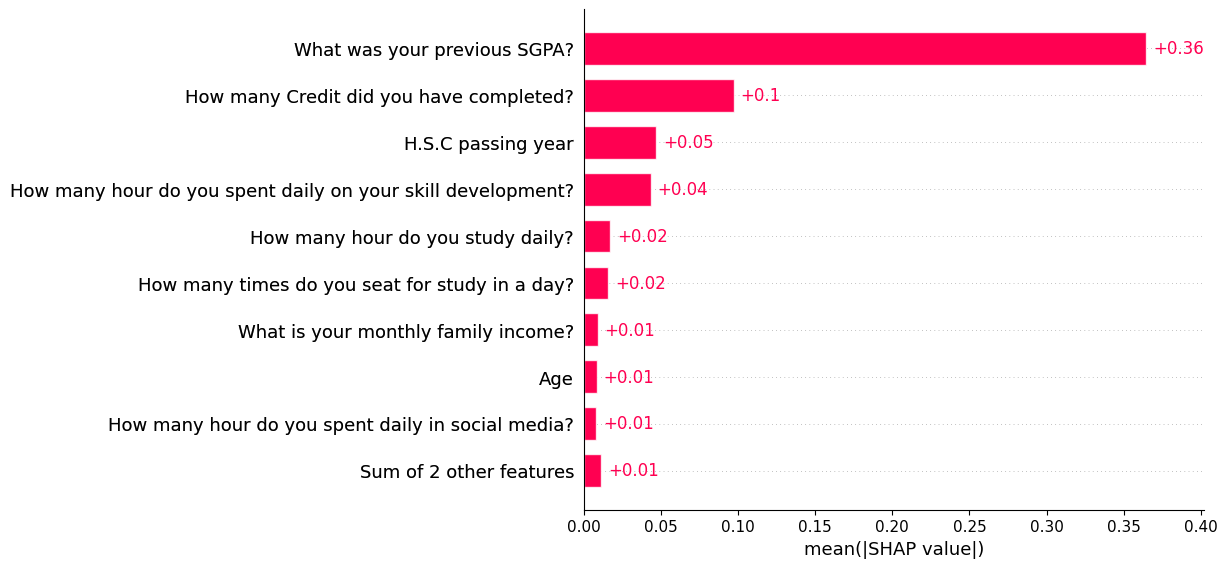

In [ ]:
# Step 12: SHAP Value Analysis for Numerical Attributes

# 1. Use only numerical test features for SHAP
num_test_subset = num_test[:50] # Use a smaller subset for explanation
cat_test_subset = cat_test[:50] # Corresponding categorical data

# 2. Create a prediction function for SHAP that takes only numerical features
def predict_fn(x_num_numpy):
    x_num_tensor = torch.tensor(x_num_numpy, dtype=torch.float32).to(device)

    # Use fixed dummy categorical and neighbor data for all predictions
    # Using the first sample's data as dummy
    dummy_cat = torch.tensor(cat_train[0:1], dtype=torch.long).to(device)
    dummy_num = torch.tensor(num_train[0:1], dtype=torch.float32).to(device)
    dummy_neigh_cat = torch.tensor(cat_train[0:model.k], dtype=torch.long).unsqueeze(0).to(device) # Shape (1, k, num_cat_features)
    dummy_neigh_num = torch.tensor(num_train[0:model.k], dtype=torch.float32).unsqueeze(0).to(device) # Shape (1, k, num_num_features)


    with torch.no_grad():
        # Repeat dummy data for the batch size of the input numerical features
        batch_size = x_num_tensor.size(0)
        dummy_cat_batch = dummy_cat.repeat(batch_size, 1)
        # dummy_num_batch is not needed as input is already numerical
        dummy_neigh_cat_batch = dummy_neigh_cat.repeat(batch_size, 1, 1)
        dummy_neigh_num_batch = dummy_neigh_num.repeat(batch_size, 1, 1)


        # The model expects x_cat, x_num, neigh_cat, neigh_num
        preds = model(dummy_cat_batch, x_num_tensor, dummy_neigh_cat_batch, dummy_neigh_num_batch)
    return preds.cpu().numpy()

# Select a smaller background dataset for SHAP (e.g., a subset of the training data numerical features)
background_data_num = num_train[:100]

# Select some test data numerical features for explanation
X_test_num_subset = num_test[:50]

# Initialize SHAP Explainer with the prediction function and background data
explainer = shap.Explainer(predict_fn, background_data_num)
shap_values = explainer(X_test_num_subset)

# 4. Use actual numerical column names
numerical_feature_names = numerical_columns

# 5. SHAP bar plot with real attribute names
shap_explanation = shap.Explanation(values=shap_values.values,
                                    base_values=shap_values.base_values,
                                    data=X_test_num_subset,
                                    feature_names=numerical_feature_names)
shap.plots.bar(shap_explanation, max_display=10)